In [1]:
from argparse import Namespace
import numpy as np
import torch
import torch.nn.functional as F
import math

import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from src.util import make_faces, grid_to_list

from src.vertex_normals import VertexNormals 

In [2]:
side =  1024
blueprint = np.load(f'./data/blueprint_radial_{side}.npz') 
points = torch.tensor(blueprint['points'])
normals = torch.tensor(blueprint['normals'])
print(points.shape, normals.shape)
points, normals = grid_to_list(points), grid_to_list(normals)
points.shape, normals.shape

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 3, 1024, 1024])


(torch.Size([1, 1048576, 3]), torch.Size([1, 1048576, 3]))

In [3]:
opt = Namespace()
opt.data_dir = './data/'
opt.data_patch_size = side
print(opt)

vn = VertexNormals(opt, load=False)
calc_normals = vn(points)
calc_normals.shape

Namespace(data_dir='./data/', data_patch_size=1024)


torch.Size([1, 1048576, 3])

In [4]:
elm_dot = torch.sum(calc_normals * normals, dim=-1).reshape(side, side)
print(elm_dot.shape)

torch.Size([1024, 1024])


In [5]:
elm_dot.mean()

tensor(0.0315)

(1024, 1024) (1024, 1024)


<ipython-input-15-476cbf1faad5>:7: UserWarning:

The following kwargs were not used by contour: 'lw'

<ipython-input-15-476cbf1faad5>:8: UserWarning:

The following kwargs were not used by contour: 'lw'



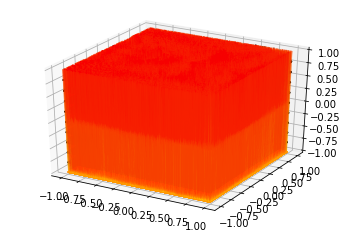

In [15]:



fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:1024j, -1:1:1024j]
print(X.shape, Y.shape)
Z = elm_dot.cpu().numpy()
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1, alpha=0.5)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show();

In [16]:
elm_dot

tensor([[ 1.0000,  0.9997, -0.0416,  ...,  0.9999,  0.0207,  0.0000],
        [-0.9999,  0.9992,  0.9997,  ..., -0.9991, -0.9995, -0.9999],
        [-0.9999, -0.9992,  0.9990,  ..., -0.9970, -0.9999, -0.9999],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])

tensor(-0.0318)

In [7]:
import trimesh

In [ ]:
 def test_strips(self):
        """
        Test our conversion of triangle strips to face indexes.
        """

        def strips_to_faces(strips):
            """
            A slow but straightforward version of the function to test against
            """
            faces = g.collections.deque()
            for s in strips:
                s = g.np.asanyarray(s, dtype=g.np.int)
                # each triangle is defined by one new vertex
                tri = g.np.column_stack([g.np.roll(s, -i)
                                         for i in range(3)])[:-2]
                # we need to flip ever other triangle
                idx = (g.np.arange(len(tri)) % 2).astype(bool)
                tri[idx] = g.np.fliplr(tri[idx])
                faces.append(tri)
            # stack into one (m,3) array
            faces = g.np.vstack(faces)
            return faces

        # test 4- triangle strip
        s = [g.np.arange(6)]
        f = g.trimesh.util.triangle_strips_to_faces(s)
        assert (f == g.np.array([[0, 1, 2],
                                 [3, 2, 1],
                                 [2, 3, 4],
                                 [5, 4, 3]])).all()
        assert len(f) + 2 == len(s[0])
        assert (f == strips_to_faces(s)).all()

        # test single triangle
        s = [g.np.arange(3)]
        f = g.trimesh.util.triangle_strips_to_faces(s)
        assert (f == g.np.array([[0, 1, 2]])).all()
        assert len(f) + 2 == len(s[0])
        assert (f == strips_to_faces(s)).all()

        s = [g.np.arange(100)]
        f = g.trimesh.util.triangle_strips_to_faces(s)
        assert len(f) + 2 == len(s[0])
        assert (f == strips_to_faces(s)).all()

In [14]:
s = [np.arange(6), np.array([1, ])]
s

[array([0, 1, 2, 3, 4, 5])]

In [18]:
f = trimesh.util.triangle_strips_to_faces([
  [0, 4, 1, 5, 2, 6, 3, 7],
  [4, 8, 5, 9, 6, 10, 7, 11]
])
print(f.shape)
f

(12, 3)


array([[ 0,  4,  1],
       [ 5,  1,  4],
       [ 1,  5,  2],
       [ 6,  2,  5],
       [ 2,  6,  3],
       [ 7,  3,  6],
       [ 4,  8,  5],
       [ 9,  5,  8],
       [ 5,  9,  6],
       [10,  6,  9],
       [ 6, 10,  7],
       [11,  7, 10]])

In [23]:
# 0  1  2  3
# 4  5  6  7
# 8  9 10 11
def create_strips(n, m):
    res = []
    for i in range(n-1):
        strip = []
        for j in range(m):            
            strip.append(j+i*m)
            strip.append(j+(i+1)*m)
        res.append(strip)
    return res

create_strips(3, 4)

[[0, 4, 1, 5, 2, 6, 3, 7], [4, 8, 5, 9, 6, 10, 7, 11]]

In [25]:
def create_strips(n):
    res = []
    for i in range(n-1):
        strip = []
        for j in range(n):            
            strip.append(j+i*n)
            strip.append(j+(i+1)*n)
        res.append(strip)
    return res

create_strips(4)

[[0, 4, 1, 5, 2, 6, 3, 7],
 [4, 8, 5, 9, 6, 10, 7, 11],
 [8, 12, 9, 13, 10, 14, 11, 15]]

In [26]:
trimesh.util.triangle_strips_to_faces(create_strips(4))

array([[ 0,  4,  1],
       [ 5,  1,  4],
       [ 1,  5,  2],
       [ 6,  2,  5],
       [ 2,  6,  3],
       [ 7,  3,  6],
       [ 4,  8,  5],
       [ 9,  5,  8],
       [ 5,  9,  6],
       [10,  6,  9],
       [ 6, 10,  7],
       [11,  7, 10],
       [ 8, 12,  9],
       [13,  9, 12],
       [ 9, 13, 10],
       [14, 10, 13],
       [10, 14, 11],
       [15, 11, 14]])

In [29]:
trimesh.util.triangle_strips_to_faces(create_strips(4, 4))

array([[ 0,  4,  1],
       [ 5,  1,  4],
       [ 1,  5,  2],
       [ 6,  2,  5],
       [ 2,  6,  3],
       [ 7,  3,  6],
       [ 4,  8,  5],
       [ 9,  5,  8],
       [ 5,  9,  6],
       [10,  6,  9],
       [ 6, 10,  7],
       [11,  7, 10],
       [ 8, 12,  9],
       [13,  9, 12],
       [ 9, 13, 10],
       [14, 10, 13],
       [10, 14, 11],
       [15, 11, 14]])

In [27]:
make_faces(4, 4)

array([[ 0,  1,  4],
       [ 1,  5,  4],
       [ 1,  2,  5],
       [ 2,  6,  5],
       [ 2,  3,  6],
       [ 3,  7,  6],
       [ 4,  5,  8],
       [ 5,  9,  8],
       [ 5,  6,  9],
       [ 6, 10,  9],
       [ 6,  7, 10],
       [ 7, 11, 10],
       [ 8,  9, 12],
       [ 9, 13, 12],
       [ 9, 10, 13],
       [10, 14, 13],
       [10, 11, 14],
       [11, 15, 14]])

In [28]:
def create_strips(n, m):
    res = []
    for i in range(n-1):
        strip = []
        for j in range(m):            
            strip.append(j+i*m)
            strip.append(j+(i+1)*m)
        res.append(strip)
    return res

create_strips(4, 4)

[[0, 4, 1, 5, 2, 6, 3, 7],
 [4, 8, 5, 9, 6, 10, 7, 11],
 [8, 12, 9, 13, 10, 14, 11, 15]]

In [5]:
from trimesh.util import triangle_strips_to_faces
#from src.util import make_faces

def create_strips(n, m):
    res = []
    for i in range(n-1):
        strip = []
        for j in range(m):            
            strip.append(j+(i+1)*m)
            strip.append(j+i*m)
        res.append(strip)
    return res

def make_faces(n, m):
    strips = create_strips(n, m)
    print(strips)
    return triangle_strips_to_faces(strips)

make_faces(256, 256)

[[256, 0, 257, 1, 258, 2, 259, 3, 260, 4, 261, 5, 262, 6, 263, 7, 264, 8, 265, 9, 266, 10, 267, 11, 268, 12, 269, 13, 270, 14, 271, 15, 272, 16, 273, 17, 274, 18, 275, 19, 276, 20, 277, 21, 278, 22, 279, 23, 280, 24, 281, 25, 282, 26, 283, 27, 284, 28, 285, 29, 286, 30, 287, 31, 288, 32, 289, 33, 290, 34, 291, 35, 292, 36, 293, 37, 294, 38, 295, 39, 296, 40, 297, 41, 298, 42, 299, 43, 300, 44, 301, 45, 302, 46, 303, 47, 304, 48, 305, 49, 306, 50, 307, 51, 308, 52, 309, 53, 310, 54, 311, 55, 312, 56, 313, 57, 314, 58, 315, 59, 316, 60, 317, 61, 318, 62, 319, 63, 320, 64, 321, 65, 322, 66, 323, 67, 324, 68, 325, 69, 326, 70, 327, 71, 328, 72, 329, 73, 330, 74, 331, 75, 332, 76, 333, 77, 334, 78, 335, 79, 336, 80, 337, 81, 338, 82, 339, 83, 340, 84, 341, 85, 342, 86, 343, 87, 344, 88, 345, 89, 346, 90, 347, 91, 348, 92, 349, 93, 350, 94, 351, 95, 352, 96, 353, 97, 354, 98, 355, 99, 356, 100, 357, 101, 358, 102, 359, 103, 360, 104, 361, 105, 362, 106, 363, 107, 364, 108, 365, 109, 366, 110

array([[  256,     0,   257],
       [    1,   257,     0],
       [  257,     1,   258],
       ...,
       [65278, 65534, 65277],
       [65534, 65278, 65535],
       [65279, 65535, 65278]])